# Best-Case $\varepsilon$-Outage Capacity of Rayleigh Fading Channels

_Author:_ Karl-Ludwig Besser, Technische Universität Braunschweig

This notebook is part of the paper "Reliability Bounds for Dependent Fading Wireless Channels", K.-L. Besser and E. Jorswieck, IEEE Transactions on Wireless Communications, 2020 ([arXiv:1909.01415[cs.IT]](https://arxiv.org/abs/1909.01415), [DOI:10.1109/TWC.2020.2997332](https://doi.org/10.1109/TWC.2020.2997332)).  
If you use any of this work, please cite the above paper.

## Introduction

In the following, the best-case $\varepsilon$-capacity $\overline{R}^{\varepsilon}$ for Rayleigh fading channels is shown.

In the case of Rayleigh fading, all $\left|h\right|^2\sim\exp(1)$ are exponentially distributed.  
The final expression for $\overline{R}^{\varepsilon}$ is given by
$$\overline{R}^{\varepsilon}(\rho) = \log_2\left(1+\rho \cdot \phi(\varepsilon)\right),$$
where $\rho$ is the SNR and $\phi$ is derived from [[Wang et al., 2013, Eq. (3.8)]](https://doi.org/10.1007/s00780-012-0200-5) for $X_i\sim\exp(1)$.  
Please refer to the paper for details.

The following code shows the (numerical) calculations.

_Note:_ The calculations for the worst-case capacity $\underline{R}^{\varepsilon}$ are shown in the notebook [Worst-Case Epsilon-Outage Capacity of Rayleigh Fading Channels](worst-case-epsilon-outage-rayleigh.ipynb). A comparison of worst-case, best-case and iid-case is presented in the notebook [Outage Capacity Rayleigh Channel](Outage%20Capacity%20Rayleigh%20Channel.ipynb).

In [1]:
import numpy as np
from scipy import optimize
%matplotlib notebook
import matplotlib.pyplot as plt
from ipywidgets import interact

## Basic Functions

In [2]:
# Exponential distribution (decreasing density)
def pdf(x):  # f
    return np.exp(-x)

def cdf(x):  # F
    return 1-np.exp(-x)

def inv_cdf(x):  # G
    return -np.log(1-x)

In [3]:
def H(x, n, a):
    return (n-1)*inv_cdf(a+(n-1)*x) + inv_cdf(1-x)

def T(x, n, a):  # Integral of H_a(x)
    return n*x - x*np.log(x) + (1-a+x-n*x)*np.log(1-a+x-n*x)

def psi(a):  # conditional expectation psi(a) = E[X|X > G(a)]
    if a == 1:
        return np.inf
    return 1 - np.log(1-a)

In [4]:
# Calculation of cmin [Wang et al., 2013, Eq. (3.7)]
def lhs_cmin(c, n, a):
    if c == 0:
        return (-1 + a)*(-1 + np.log(1-a))
    return (1-a)-(c*n - c*np.log(c) + (1-a+c-c*n)*np.log(1-a+c-c*n))

def rhs_cmin(c, n, a):
    return ((1-a)/n-c)*H(c, n, a)

def diff_cmin(c, n, a):
    return lhs_cmin(c, n, a) - rhs_cmin(c, n, a)


def determine_cmin(n, a):
    _eps = np.finfo(float).eps
    x0 = ((1-a)/n+_eps)/2
    bracket = [0+_eps, (1-a)/(n*(n-1))]
    try:
        solution = optimize.root_scalar(diff_cmin, args=(n, a), x0=x0,
                                        bracket=bracket)
    except ValueError as e:
        print("Error during root solving for n={:d}, a={:.2f}: {}".format(n, a, e))
        return -1
    return solution.root

In [5]:
# Function phi(a) for decreasing density
def phi(a, n, cmin=None):
    if cmin is None:
        cmin = determine_cmin(n, a)
    if cmin > 0:
        _phi = H(cmin, n, a)
    elif cmin == 0:
        _phi = n*psi(a)
    else:
        raise ValueError("cmin must not be negative!")
    return _phi

## Rate Calculation

The rate is derived from the following solution for the outage-capacity
$$s^{\star} = \phi(\varepsilon) = \frac{2^{\overline{R}^{\varepsilon}}-1}{\rho}.$$

Please refer to the paper for details about this relation.

In [6]:
def calc_rate(eps, snr, n):
    return np.log2(1. + snr*phi(eps, n))

## Plots of Different Relations

### Influence of a on cmin

<IPython.core.display.Javascript object>


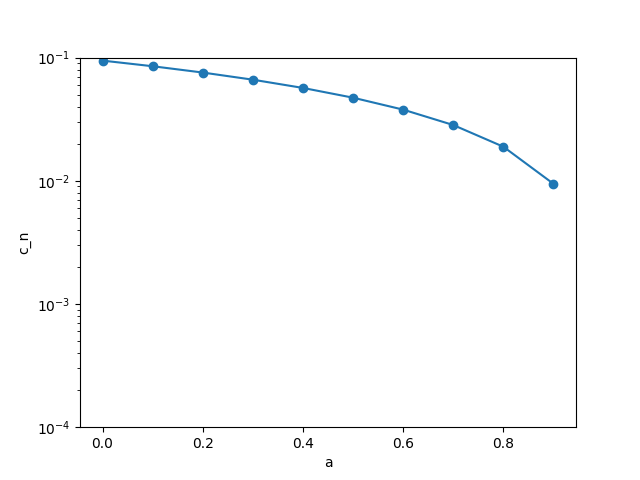

interactive(children=(IntSlider(value=3, description='n', max=9, min=3), Output()), _dom_classes=('widget-inte…

In [7]:
def cmin_plot_a():
    fig, ax = plt.subplots(num="c_n vs a")
    ax.set_xlabel("a")
    ax.set_ylabel("c_n")
    ax.set_ylim([1e-4, .1])
    a = np.arange(0, 1, .1)
    cmin = [determine_cmin(3, _a) for _a in a]
    _plot = ax.semilogy(a, cmin, 'o-')[0]
    
    def update_plot(n=0):
        _plot.set_ydata([determine_cmin(n, _a) for _a in a])
        fig.canvas.draw_idle()
    
    interact(update_plot, n=(3, 9, 1))

cmin_plot_a()

It can be seen that $c_n(a)$ decreases with increasing $a$ and approaches zero. It is also decreasing with increasing $n$, however, it never actually reaches zero.

### Outage Rate

<IPython.core.display.Javascript object>


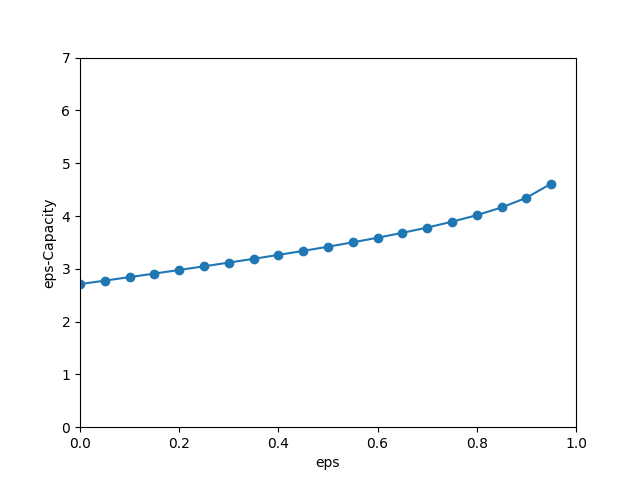

interactive(children=(IntSlider(value=3, description='n', max=10, min=3), IntSlider(value=3, description='snr_…

In [8]:
def outage_rate_plot(snr_init=3, n_init=3):
    fig, ax = plt.subplots(num='Worst-Case Epsilon-Outage Capacity')
    ax.set_ylabel("eps-Capacity")
    ax.set_xlabel("eps")
    eps = np.arange(0, 1, .05)
    _rate = [calc_rate(_eps, snr_init, n_init) for _eps in eps]
    _plot = ax.plot(eps, _rate, 'o-')[0]
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 7])

    def update_plot(n=n_init, snr_db=snr_init):
        snr = 10**(snr_db/10.)
        _plot.set_ydata([calc_rate(_eps, snr, n) for _eps in eps])
        fig.canvas.draw_idle()

    interact(update_plot, n=(3, 10, 1), snr_db=(-2, 10, 2))

outage_rate_plot()

It can be seen that the best-case $\varepsilon$-outage capacity increases with increasing $\varepsilon$. It also increases with increasing $n$ and $\rho$. One more important fact is, that it is always positive. Therefore, even the zero-outage capacity is greater than zero in the best case.